In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from sklearn import preprocessing

from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from scipy.spatial import distance

from ibmdata.plot.wafermap import wafermap, wafermap_gallery, WafermapConfig
import matplotlib as mpl

Discreet Cosine Transform

$$x = 1,2,....P \quad y = 1,2,....Q \quad in\ cartesian\ domain$$
$$u = 1,2,....P \quad v = 1,2,....Q \quad in\ frequency\ domain$$

$$A_{u,v}(x,y) = \alpha_u\beta_v\cos{\frac{\pi(2x-1)(u-1)}{2P}}\cos{\frac{\pi(2y-1)(v-1)}{2Q}}$$

$$\alpha_u =\begin{cases}
            \sqrt{\frac{1}{P}} & (u=1) \\
            \sqrt{\frac{2}{P}} & (2 \leq u \leq P)
            \end{cases}
  \qquad
  \beta_v = \begin{cases}
            \sqrt{\frac{1}{Q}} & (v=1) \\
            \sqrt{\frac{2}{Q}} & (2 \leq v \leq Q)
            \end{cases}
$$

For P10 DD2, P = 1:11 Q = 1:10

For zA DD2, P = 1:11 Q = 1:11

In [2]:
def DCT(P,Q,x,y,ignore=[]):
    A = []
    for u in range(1,P+1):
        for v in range(1,Q+1):
            if u == 1:
                alpha = np.sqrt(1/P)
            else:
                alpha = np.sqrt(2/P)
            if v == 1:
                beta = np.sqrt(1/Q)
            else:
                beta = np.sqrt(2/Q)
            transform = alpha*beta*np.cos((np.pi*(2*x-1)*(u-1))/(2*P))*np.cos((np.pi*(2*y-1)*(v-1))/(2*Q))
            if (u,v) in ignore:
                transform = 0
            A.append(transform)
    return np.array(A)

def DFT(P,Q,x,y,ignore=[]):
    A = []
    for u in range(1,P+1):
        for v in range(1,Q+1):
            transform = (1/(P*Q))*np.exp(-1j*2*np.pi*(x*u/P + y*v/P))
            if (u,v) in ignore:
                transform = 0
            A.append(transform)
    return np.array(A)
                
def pullxy(df,x,y,minusone=True):
    if minusone == True:
        return df[[x,y]].apply(lambda x: x-1).values.tolist()
    else:
        return df[[x,y]].values.tolist()

def fillA(xy,prod,DCT = True):
    A = []
    P10ignore = [(1,1),(1,2),(1,3),(2,1),(3,1),(4,1),(2,2),(8,1),(9,1),(10,1),(11,1),
                 (10,2),(11,2),(11,3),(11,4),(11,7),(11,8),(10,9),(11,9),(8,10),(9,10),
                 (10,10),(11,10),(1,8),(1,9),(2,9),(1,10),(2,10),(3,10),(4,10)]
    zAignore = [(1,1),(1,2),(1,3),(1,4),(2,1),(3,1),(4,1),(2,2),(8,1),(9,1),(10,1),(11,1),
                (10,2),(11,2),(11,3),(11,4),(11,8),(11,9),(10,10),(11,10),(8,11),(9,11),
                (10,11),(1,8),(1,9),(1,10),(2,10),(1,11),(2,11),(3,11),(4,11)]
    if prod == 'P10DD2':
        P,Q = 11,10
        ignore = P10ignore
    elif prod == 'zADD2':
        P,Q = 11,11
        ignore = zAignore
    if DCT == True:
        for x,y in xy:
            A.append(DCT(P,Q,x,y,ignore))
    else:
        for x,y in xy:
            A.append(abs(DFT(P,Q,x,y,ignore)))
    return np.array(A)

def translate_idx_to_uv(idx, Q):
    x = idx//Q + 1
    #y = Q - (idx%Q + 1) + 1
    y = idx%Q + 1
    return (x,y)

def parseData(df, normalize = False, groupby = 'wafer_id', b_input = None, x = 'unitcell_x', y = 'unitcell_y', family_code = 'P10DD2',DCT = True):
    wafers = df[groupby].unique()
    B = []
    Alpha = []
    for waferid in wafers:
        cur_df = df[df[groupby]== waferid]
        b = np.array(cur_df[b_input])
        xy = pullxy(cur_df,x,y)
        A = fillA(xy,family_code, DCT = DCT)
        if normalize:
            B.append(preprocessing.normalize(np.array([b]))[0])
        else:
            B.append(b)
        Alpha.append(A)
    return wafers, B, Alpha

def createEuclidianDistanceMatrix(etas):
    output = []
    for a in etas:
        row = []
        for b in etas:
            row.append(distance.euclidean(a,b))
        output.append(row)
    return output

In [43]:
#df = pd.read_csv("p10_za_wft_sram_dbc_fails.csv")
df = pd.read_csv('PELEDBC.csv')

In [44]:
df = df.dropna()

In [45]:
df

,lot_id,wafer_id,date,family_code,unitcell_x,unitcell_y,dbc_count,geographykey,normalized_testx,normalized_testy,dbc_yield
1,A2115.1,A2115-01,5/2/22,Q6,2,5,0,66858701.0,8.0,43.0,0
2,A2115.1,A2115-01,5/2/22,Q6,2,6,0,66858714.0,8.0,54.0,0
3,A2115.1,A2115-01,5/2/22,Q6,2,7,0,66858654.0,8.0,65.0,0
4,A2115.1,A2115-01,5/2/22,Q6,2,8,0,66858667.0,8.0,76.0,0
6,A2115.1,A2115-01,5/2/22,Q6,3,4,0,66858765.0,17.0,32.0,0
...,...,...,...,...,...,...,...,...,...,...,...
18583,A2AZ8.1,A2AZ8-25,5/8/22,Q6,11,7,0,66859699.0,89.0,65.0,0
18584,A2AZ8.1,A2AZ8-25,5/8/22,Q6,11,8,0,66859785.0,89.0,76.0,0
18585,A2AZ8.1,A2AZ8-25,5/8/22,Q6,11,9,0,66859798.0,89.0,87.0,0
18587,A2AZ8.1,A2AZ8-25,5/8/22,Q6,12,6,0,66859766.0,98.0,54.0,0


In [49]:
B[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
df = df[df.schema == 'p10dd2']

AttributeError: 'DataFrame' object has no attribute 'schema'

In [3]:
wafers, B, Alpha = parseData(df, normalize = False, groupby = 'wafer_id', b_input ='dbc_yield', x = 'unitcell_x', y = 'unitcell_y', family_code = 'P10DD2',DCT = False)

NameError: name 'df' is not defined

In [108]:
etas = []
nonzero_indices = []
for i in range(len(wafers)):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=15, normalize=False)
    omp.fit(Alpha[i], B[i])
    coef = omp.coef_
    (idx_r,) = coef.nonzero()
    etas.append(coef)
    nonzero_indices.append(idx_r)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:389: RuntimeWarning:

 Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:389: RuntimeWarning:

 Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:389: RuntimeWarning:

 Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:389: RuntimeWarning:

 Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:389:

In [118]:
DistMatrix = createEuclidianDistanceMatrix(etas)
dists = squareform(DistMatrix)
linkage_matrix = linkage(dists, "complete")

In [223]:
results = fcluster(linkage_matrix, t=5, criterion='distance')

In [125]:
results = fcluster(linkage_matrix, t=9, criterion='maxclust')

In [126]:
results

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [76]:
from collections import defaultdict
clusters = defaultdict(list)
for i, c in enumerate(results):
    clusters[c].append(wafers[i])

In [77]:
for i in range(1,len(clusters)+1):
    print(i, len(clusters[i]))

1 188
2 10
3 11


In [78]:
import random
#plotdf = df[df['wafer_id'].isin(random.choices(clusters[68],k=8))]
plotdf = df[df['wafer_id'].isin(clusters[3][0:8])]
width = 800
height = 500
columns = 2

display(
    wafermap_gallery(
        WafermapConfig(
            plotdf, 
            chipx_column='normalized_testx', 
            chipy_column='normalized_testy', 
            color_by_column='dbc_yield', 
            colormap = mpl.cm.RdYlGn.reversed(),
            #discrete=True, 
            title=f"wafermaps",
            plot_type='plotly',
            #plot_type='mpl',
            width=width,
            height=height,
            show_kerf_borders=False
        ), 
        wafer_column='wafer_id',
        columns = columns
    )
)

/usr/local/lib/python3.9/site-packages/ibmdata/plot/wafermap/_plotly.py:459: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.9/site-packages/ibmdata/plot/wafermap/_plotly.py:460: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



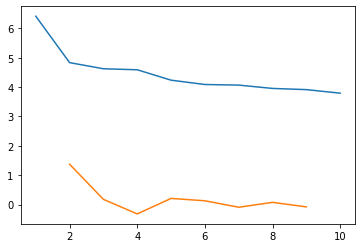

In [237]:
last = linkage_matrix[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters

In [136]:
linkage_matrix[-10:, 2]

array([ 19.24709631,  19.8790373 ,  22.22493467,  23.19154922,
        29.14870736,  34.11335841,  41.10295558,  52.46534213,
        60.08168868, 110.51306908])

In [140]:
linkage_matrix[-10:,2]

array([ 19.24709631,  19.8790373 ,  22.22493467,  23.19154922,
        29.14870736,  34.11335841,  41.10295558,  52.46534213,
        60.08168868, 110.51306908])

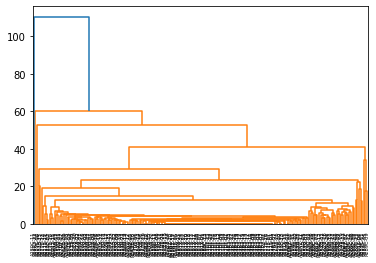

<Figure size 18000x7200 with 0 Axes>

In [170]:
dendrogram(linkage_matrix, labels=wafers)
plt.figure(figsize=(250, 100))
plt.show()

In [180]:
resultsdf = pd.DataFrame(data={'wafer_id':wafers, 'result':results})
resultsdf['wafer_cnt'] = resultsdf.groupby('result').wafer_id.transform('count')
classifieddf = pd.merge(df, resultsdf, on=['wafer_id'], how='left')
print(len(classifieddf['wafer_id'].unique()))
print(len(classifieddf['result'].unique()))
display(classifieddf)

209
41


,lot_id,wafer_id,date,family_code,unitcell_x,unitcell_y,dbc_count,geographykey,normalized_testx,normalized_testy,result,wafer_cnt
0,A2115.1,A2115-01,2022-05-02,Q6,2,5,0,66858701.0,8.0,43.0,10,153
1,A2115.1,A2115-01,2022-05-02,Q6,2,6,0,66858714.0,8.0,54.0,10,153
2,A2115.1,A2115-01,2022-05-02,Q6,2,7,0,66858654.0,8.0,65.0,10,153
3,A2115.1,A2115-01,2022-05-02,Q6,2,8,0,66858667.0,8.0,76.0,10,153
4,A2115.1,A2115-01,2022-05-02,Q6,3,4,0,66858765.0,17.0,32.0,10,153
...,...,...,...,...,...,...,...,...,...,...,...,...
16707,A2AZ8.1,A2AZ8-25,2022-05-08,Q6,11,7,0,66859699.0,89.0,65.0,10,153
16708,A2AZ8.1,A2AZ8-25,2022-05-08,Q6,11,8,0,66859785.0,89.0,76.0,10,153
16709,A2AZ8.1,A2AZ8-25,2022-05-08,Q6,11,9,0,66859798.0,89.0,87.0,10,153
16710,A2AZ8.1,A2AZ8-25,2022-05-08,Q6,12,6,0,66859766.0,98.0,54.0,10,153


[<AxesSubplot:title={'center':'1-1'}>,
 <AxesSubplot:title={'center':'2-1'}>,
 <AxesSubplot:title={'center':'3-2'}>,
 <AxesSubplot:title={'center':'4-1'}>,
 <AxesSubplot:title={'center':'5-1'}>,
 <AxesSubplot:title={'center':'6-2'}>,
 <AxesSubplot:title={'center':'7-1'}>,
 <AxesSubplot:title={'center':'8-2'}>,
 <AxesSubplot:title={'center':'9-3'}>,
 <AxesSubplot:title={'center':'10-153'}>,
 <AxesSubplot:title={'center':'11-1'}>,
 <AxesSubplot:title={'center':'12-1'}>,
 <AxesSubplot:title={'center':'13-1'}>,
 <AxesSubplot:title={'center':'14-1'}>,
 <AxesSubplot:title={'center':'15-3'}>,
 <AxesSubplot:title={'center':'16-7'}>,
 <AxesSubplot:title={'center':'17-1'}>,
 <AxesSubplot:title={'center':'18-2'}>,
 <AxesSubplot:title={'center':'19-1'}>,
 <AxesSubplot:title={'center':'20-1'}>,
 <AxesSubplot:title={'center':'21-1'}>,
 <AxesSubplot:title={'center':'22-1'}>,
 <AxesSubplot:title={'center':'23-2'}>,
 <AxesSubplot:title={'center':'24-2'}>,
 <AxesSubplot:title={'center':'25-1'}>,
 <AxesS

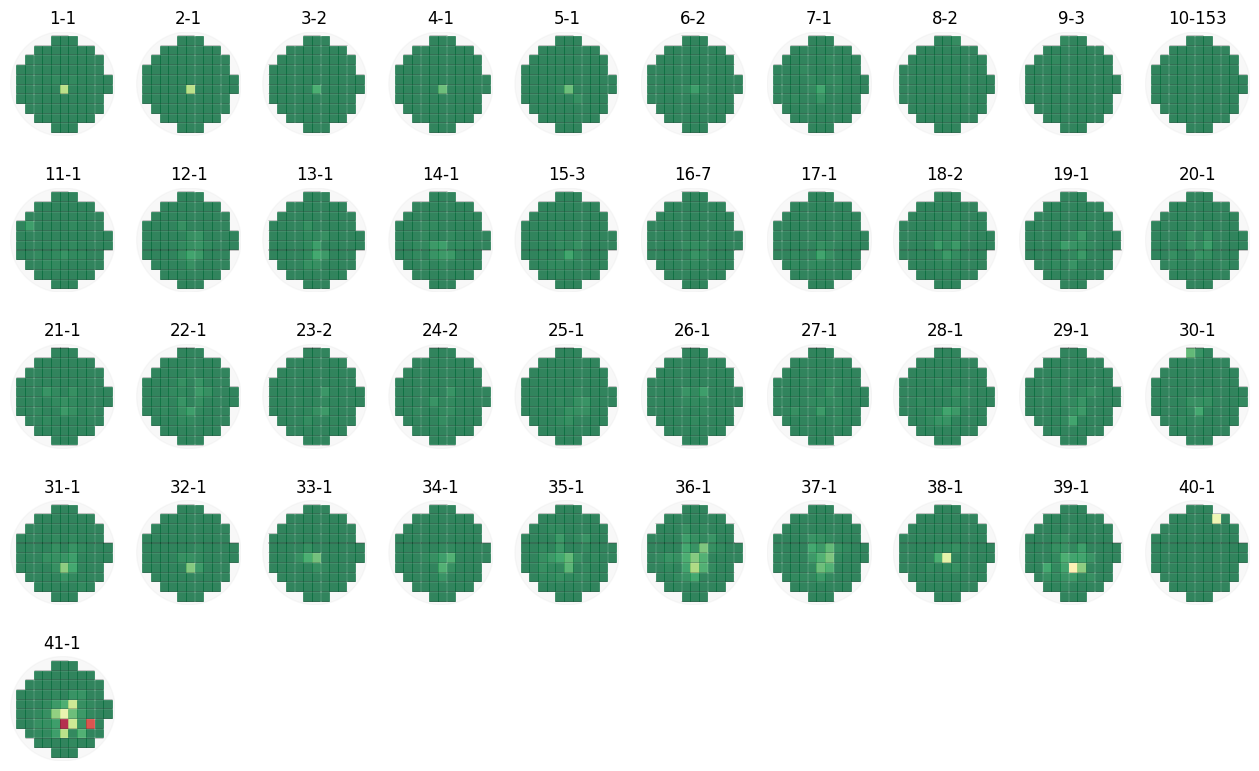

In [185]:
failcol = 'dbc_count'
plotdf = classifieddf.groupby(['normalized_testx','normalized_testy','geographykey','result','wafer_cnt']).agg({failcol:'mean'}).reset_index()
plotdf['result'] = plotdf['result'].astype(str) + '-' + plotdf['wafer_cnt'].astype(str)
#plotdf['result'] = plotdf['result'].astype(object)

width = 1600
height = 1000
columns = 10

display(
    wafermap_gallery(
        WafermapConfig(
            plotdf, 
            chipx_column='normalized_testx', 
            chipy_column='normalized_testy', 
            color_by_column=failcol, 
            colormap = mpl.cm.RdYlGn.reversed(),
            #discrete=True, 
            title=f"wafermaps",
            #plot_type='plotly',
            plot_type='mpl',
            width=width,
            height=height,
            show_kerf_borders=False
        ), 
        wafer_column='result',
        columns = columns
    )
)

In [17]:
df[['wafer_id','unitcell_x','unitcell_y','f_per_1gb_dbc','dbccount','dbccount_chip']]

,wafer_id,unitcell_x,unitcell_y,f_per_1gb_dbc,dbccount,dbccount_chip
0,A1U67-01,8,2,0.00000,0,0
1,A1U67-01,4,3,0.00000,0,0
2,A1U67-01,5,3,0.00000,0,0
3,A1U67-01,6,3,0.00000,0,0
4,A1U67-01,8,3,0.00000,0,0
...,...,...,...,...,...,...
56032,AZD12-20,12,8,0.76404,4,0
56033,AZD12-22,12,8,0.38202,2,1
56034,AZD12-23,12,8,0.42447,2,0
56035,AZD12-24,12,8,0.00000,0,0


1 Wafer experiment

In [355]:
df = df[df.wafer_id == 'A1U67-01']

In [356]:
b = np.array(df.failcount)
xy = pullxy(df,'unitcell_x','unitcell_y')
A = fillA(xy,'P10DD2')

<StemContainer object of 3 artists>

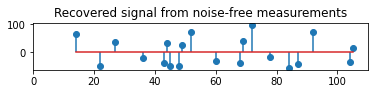

In [363]:
# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20, normalize=False)
omp.fit(A, b)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 110)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

In [370]:
b

array([  0,   0,   0,   0,   0,   3,   1,   1,   3,   0,   0,   0,   1,
         2,   0,   2,   1,   0,   8,   0,   0,   6,   0,   0,   4,   3,
         2,   0, 107,   2,   0,   0,   1,   0,   3,   6,   0,   0,   3,
         1,   0,   2,   1,   0,   0,   0,   0,   0,  79,   0,   6,   0,
         1,   0,   0,   0])

In [365]:
a = []
Q = 10
for i in idx_r:
    a.append(translate_idx_to_uv(i,Q))

In [366]:
a

[(2, 5),
 (3, 3),
 (3, 8),
 (4, 7),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 9),
 (5, 10),
 (6, 3),
 (7, 1),
 (7, 9),
 (7, 10),
 (8, 3),
 (8, 9),
 (9, 5),
 (9, 8),
 (10, 3),
 (11, 5),
 (11, 6)]

In [362]:
df[['unitcell_x','unitcell_y','failcount']]

,unitcell_x,unitcell_y,failcount
0,8,2,0
1,4,3,0
2,5,3,0
3,6,3,0
4,8,3,0
5,9,3,3
6,10,3,1
7,4,4,1
8,6,4,3
9,7,4,0


In [369]:
# input: total number of basis vectors
num_basis_vectors = 20
# B = list of b vectors, Alpha = list of A matrices
#B, Alpha = parseData(df, groupby = 'wafer_id', b_input ='failcount', x = 'unitcell_x', y = 'unitcell_y', family_code = 'P10DD2')
df = df[df.wafer_id == 'A1U67-01']
b = np.array(df.failcount)
xy = pullxy(df,'unitcell_x','unitcell_y')
A = fillA(xy,'P10DD2')



SyntaxError: invalid syntax (<ipython-input-369-e095fc86350a>, line 5)

In [2]:
from scipy.optimize import nnls

class Result(object):
    '''Result object for storing input and output data for omp.  When called from 
    `omp`, runtime parameters are passed as keyword arguments and stored in the 
    `params` dictionary.
    Attributes:
        X:  Predictor array after (optional) standardization.
        y:  Response array after (optional) standarization.
        ypred:  Predicted response.
        residual:  Residual vector.
        coef:  Solution coefficients.
        active:  Indices of the active (non-zero) coefficient set.
        err:  Relative error per iteration.
        params:  Dictionary of runtime parameters passed as keyword args.   
    '''
    
    def __init__(self, **kwargs):
        
        # to be computed
        self.X = None
        self.y = None
        self.ypred = None
        self.residual = None
        self.coef = None
        self.active = None
        self.err = None
        
        # runtime parameters
        self.params = {}
        for key, val in kwargs.items():
            self.params[key] = val
            
    def update(self, coef, active, err, residual, ypred):
        '''Update the solution attributes.
        '''
        self.coef = coef
        self.active = active
        self.err = err
        self.residual = residual
        self.ypred = ypred

def omp(X, y, nonneg=True, ncoef=None, maxit=200, tol=1e-3, ztol=1e-12, verbose=True):
    '''Compute sparse orthogonal matching pursuit solution with unconstrained
    or non-negative coefficients.
    
    Args:
        X: Dictionary array of size n_samples x n_features. 
        y: Reponse array of size n_samples x 1.
        nonneg: Enforce non-negative coefficients.
        ncoef: Max number of coefficients.  Set to n_features/2 by default.
        tol: Convergence tolerance.  If relative error is less than
            tol * ||y||_2, exit.
        ztol: Residual covariance threshold.  If all coefficients are less 
            than ztol * ||y||_2, exit.
        verbose: Boolean, print some info at each iteration.
        
    Returns:
        result:  Result object.  See Result.__doc__
    '''
    
    def norm2(x):
        return np.linalg.norm(x) / np.sqrt(len(x))
    
    # initialize result object
    result = Result(nnoneg=nonneg, ncoef=ncoef, maxit=maxit,
                    tol=tol, ztol=ztol)
    if verbose:
        print(result.params)
    
    # check types, try to make somewhat user friendly
    if type(X) is not np.ndarray:
        X = np.array(X)
    if type(y) is not np.ndarray:
        y = np.array(y)
        
    # check that n_samples match
    if X.shape[0] != len(y):
        print('X and y must have same number of rows (samples)')
        return result
    
    # store arrays in result object    
    result.y = y
    result.X = X
    
    # for rest of call, want y to have ndim=1
    if np.ndim(y) > 1:
        y = np.reshape(y, (len(y),))
        
    # by default set max number of coef to half of total possible
    if ncoef is None:
        ncoef = int(X.shape[1]/2)
    
    # initialize things
    X_transpose = X.T                        # store for repeated use
    #active = np.array([], dtype=int)         # initialize list of active set
    active = []
    coef = np.zeros(X.shape[1], dtype=float) # solution vector
    residual = y                             # residual vector
    ypred = np.zeros(y.shape, dtype=float)
    ynorm = norm2(y)                         # store for computing relative err
    err = np.zeros(maxit, dtype=float)       # relative err vector
    
    # Check if response has zero norm, because then we're done. This can happen
    # in the corner case where the response is constant and you normalize it.
    if ynorm < tol:     # the same as ||residual|| < tol * ||residual||
        print('Norm of the response is less than convergence tolerance.')
        result.update(coef, active, err[0], residual, ypred)
        return result
    
    # convert tolerances to relative
    tol = tol * ynorm       # convergence tolerance
    ztol = ztol * ynorm     # threshold for residual covariance
    
    if verbose:
        print('\nIteration, relative error, number of non-zeros')
   
    # main iteration
    for it in range(maxit):
        
        # compute residual covariance vector and check threshold
        rcov = np.dot(X_transpose, residual)
        if nonneg:
            i = np.argmax(rcov)
            rc = rcov[i]
        else:
            i = np.argmax(np.abs(rcov))
            rc = np.abs(rcov[i])
        if rc < ztol:
            print('All residual covariances are below threshold.')
            break
        
        # update active set
        if i not in active:
            #active = np.concatenate([active, [i]], axis=1)
            active.append(i)
            
        # solve for new coefficients on active set
        if nonneg:
            coefi, _ = nnls(X[:, active], y)
        else:
            coefi, _, _, _ = np.linalg.lstsq(X[:, active], y, rcond=None)
        coef[active] = coefi   # update solution
        
        # update residual vector and error
        residual = y - np.dot(X[:,active], coefi)
        ypred = y - residual
        err[it] = norm2(residual) / ynorm  
        
        # print status
        if verbose:
            print('{}, {}, {}'.format(it, err[it], len(active)))
            
        # check stopping criteria
        if err[it] < tol:  # converged
            print('\nConverged.')
            break
        if len(active) >= ncoef:   # hit max coefficients
            print('\nFound solution with max number of coefficients.')
            break
        if it == maxit-1:  # max iterations
            print('\nHit max iterations.')
    
    result.update(coef, active, err[:(it+1)], residual, ypred)
    return result

if __name__ == '__main__':
    pass

In [290]:
n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data

# y = Xw
# |x|_0 = n_nonzero_coefs

y, X, w = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)

(idx,) = w.nonzero()

In [325]:
w

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.09820563,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.43116899,  0.  

In [97]:
a = np.array([3,2])
a.shape

(2,)

In [9]:
# distort the clean signal
y_noisy = y + 0.05 * np.random.randn(len(y))

<StemContainer object of 3 artists>

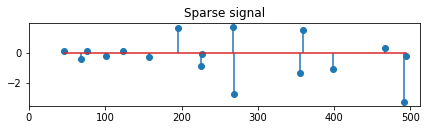

In [10]:
# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal")
plt.stem(idx, w[idx], use_line_collection=True)

<StemContainer object of 3 artists>

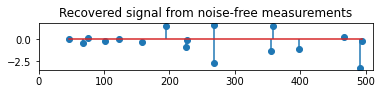

In [11]:
# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, normalize=False)
omp.fit(X, y)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

<StemContainer object of 3 artists>

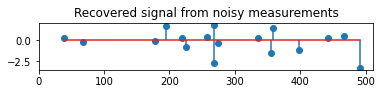

In [12]:
# plot the noisy reconstruction
omp.fit(X, y_noisy)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

<StemContainer object of 3 artists>

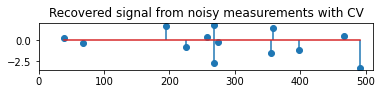

In [13]:
# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV(normalize=False)
omp_cv.fit(X, y_noisy)
coef = omp_cv.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 4)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

In [328]:
a = np.array([1,-2,3,4])

In [329]:
np.abs(a)

array([1, 2, 3, 4])